In [65]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy import signal
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
import seaborn as sea

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hadhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data=pd.read_csv('projet_data.csv')
data.head()

,Unnamed: 0,fileid,SUMMARY,DATA,categories,sub_categories,previous_appointment,ID
0,7,2.015561e+12,dizzy & double vision past 45 mins after CT,xxxx-xxxx\f0 \fswiss Arial;}}{\colortbl ;\red2...,ASK_A_DOCTOR,SYMPTOMS,No,2015_5_6141_1001
1,14,2.015562e+12,pt clld to check on a work in appt,xxxx-xxxx\f0 \fswiss Arial;}}{\colortbl ;\red2...,APPOINTMENTS,NEW APPOINTMENT,No,2015_5_6153_1001
2,17,2.015562e+12,SCHEDULED,xxxx-xxxx\f0 \fswiss Arial;}}{\colortbl ;\red2...,APPOINTMENTS,NEW APPOINTMENT,No,2015_5_6156_1001
3,18,2.015562e+12,Last office note faxed to NCEENT,{\rtf1\ansi\ftnbj{\fonttbl{\f0 \fswiss Arial;}...,MISCELLANEOUS,"SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)",No,2015_5_6158_1001
4,21,2.015562e+12,PCP Call - pt had concussion,xxxx-xxxx\f0 \fswiss Arial;}}{\colortbl ;\red2...,MISCELLANEOUS,OTHERS,No,2015_5_6162_1001


Nettoyage des données:

In [3]:
data = data.drop(['fileid', 'DATA', 'Unnamed: 0'], axis=1)

In [4]:
data.shape

(11461, 5)

In [5]:
data.categories.unique()

array(['ASK_A_DOCTOR', 'APPOINTMENTS', 'MISCELLANEOUS', 'PRESCRIPTION',
       'LAB', 'mISCELLANEOUS', 'JUNK', 'asK_A_DOCTOR'], dtype=object)

In [6]:
data.sub_categories.unique()

array(['SYMPTOMS', 'NEW APPOINTMENT',
       'SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)', 'OTHERS',
       'REFILL', 'PROVIDER', 'CANCELLATION', 'LAB RESULTS',
       'MEDICATION RELATED', 'QUERIES FROM PHARMACY',
       'PRIOR AUTHORIZATION', 'CHANGE OF PROVIDER',
       'SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)',
       'QUERIES FROM INSURANCE FIRM', 'RESCHEDULING',
       'FOLLOW UP ON PREVIOUS REQUEST', 'CHANGE OF PHARMACY',
       'QUERY ON CURRENT APPOINTMENT', 'RUNNING LATE TO APPOINTMENT',
       'CHANGE OF HOSPITAL', 'JUNK', 'mEDICATION RELATED'], dtype=object)

In [7]:
data.drop(data.loc[data['categories']=='JUNK'].index,inplace=True)
data.drop(data.loc[data['sub_categories']=='JUNK'].index,inplace=True)

Transfomer les categories et les sous-categories en minuscules 

In [8]:
data['categories'] = data['categories'].apply(lambda x:x.lower())
data['sub_categories'] = data['sub_categories'].apply(lambda x:x.lower())


In [9]:
data.head()

,SUMMARY,categories,sub_categories,previous_appointment,ID
0,dizzy & double vision past 45 mins after CT,ask_a_doctor,symptoms,No,2015_5_6141_1001
1,pt clld to check on a work in appt,appointments,new appointment,No,2015_5_6153_1001
2,SCHEDULED,appointments,new appointment,No,2015_5_6156_1001
3,Last office note faxed to NCEENT,miscellaneous,"sharing of health records (fax, e-mail, etc.)",No,2015_5_6158_1001
4,PCP Call - pt had concussion,miscellaneous,others,No,2015_5_6162_1001


In [10]:
data.drop_duplicates(keep = 'first', inplace=True)

In [11]:
data.head()

,SUMMARY,categories,sub_categories,previous_appointment,ID
0,dizzy & double vision past 45 mins after CT,ask_a_doctor,symptoms,No,2015_5_6141_1001
1,pt clld to check on a work in appt,appointments,new appointment,No,2015_5_6153_1001
2,SCHEDULED,appointments,new appointment,No,2015_5_6156_1001
3,Last office note faxed to NCEENT,miscellaneous,"sharing of health records (fax, e-mail, etc.)",No,2015_5_6158_1001
4,PCP Call - pt had concussion,miscellaneous,others,No,2015_5_6162_1001


Trouver les valeurs manquantes

In [12]:
data.isnull().sum()

SUMMARY                 712
categories                0
sub_categories            0
previous_appointment      0
ID                        0
dtype: int64

In [13]:
data=data.dropna()

In [14]:
data.shape

(10744, 5)

In [15]:
def clean_text(text):
    text=text.lower()
    text=re.sub('[^a-zA-z\s]','',text)
    text=text.strip()
    text = re.sub(" +", " ", text)
    return text
    

Compréhension des données :

In [16]:
data.categories.unique()

array(['ask_a_doctor', 'appointments', 'miscellaneous', 'prescription',
       'lab'], dtype=object)

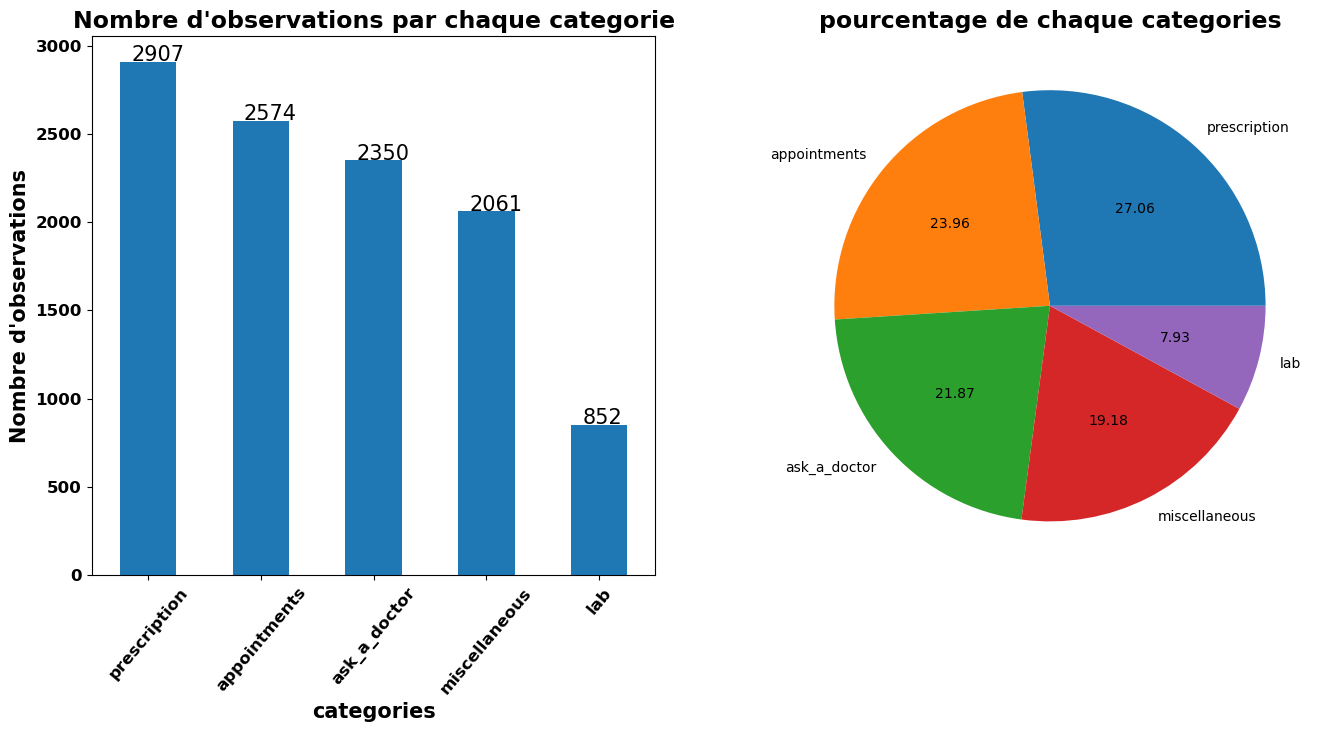

In [17]:
plt.subplots(1,2, figsize=(16,7))
plt.subplot(1,2,1)
ax=data['categories'].value_counts().plot(kind='bar')
plt.xlabel('categories',fontsize=15,fontweight='bold')
plt.xticks(rotation=50,fontsize=12,fontweight='bold')
plt.ylabel("Nombre d'observations",fontsize=15,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.title("Nombre d'observations par chaque categorie",fontsize=17,fontweight='bold')
for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()+3, str(round(i.get_height(), 2)), fontsize=15, color='black')
plt.subplot(1,2,2)
plt.pie(data['categories'].value_counts(), labels=['prescription', 'appointments', 'ask_a_doctor', 'miscellaneous',
       'lab'], autopct='%.2f')
plt.title('pourcentage de chaque categories',fontsize=17,fontweight='bold')

plt.show()

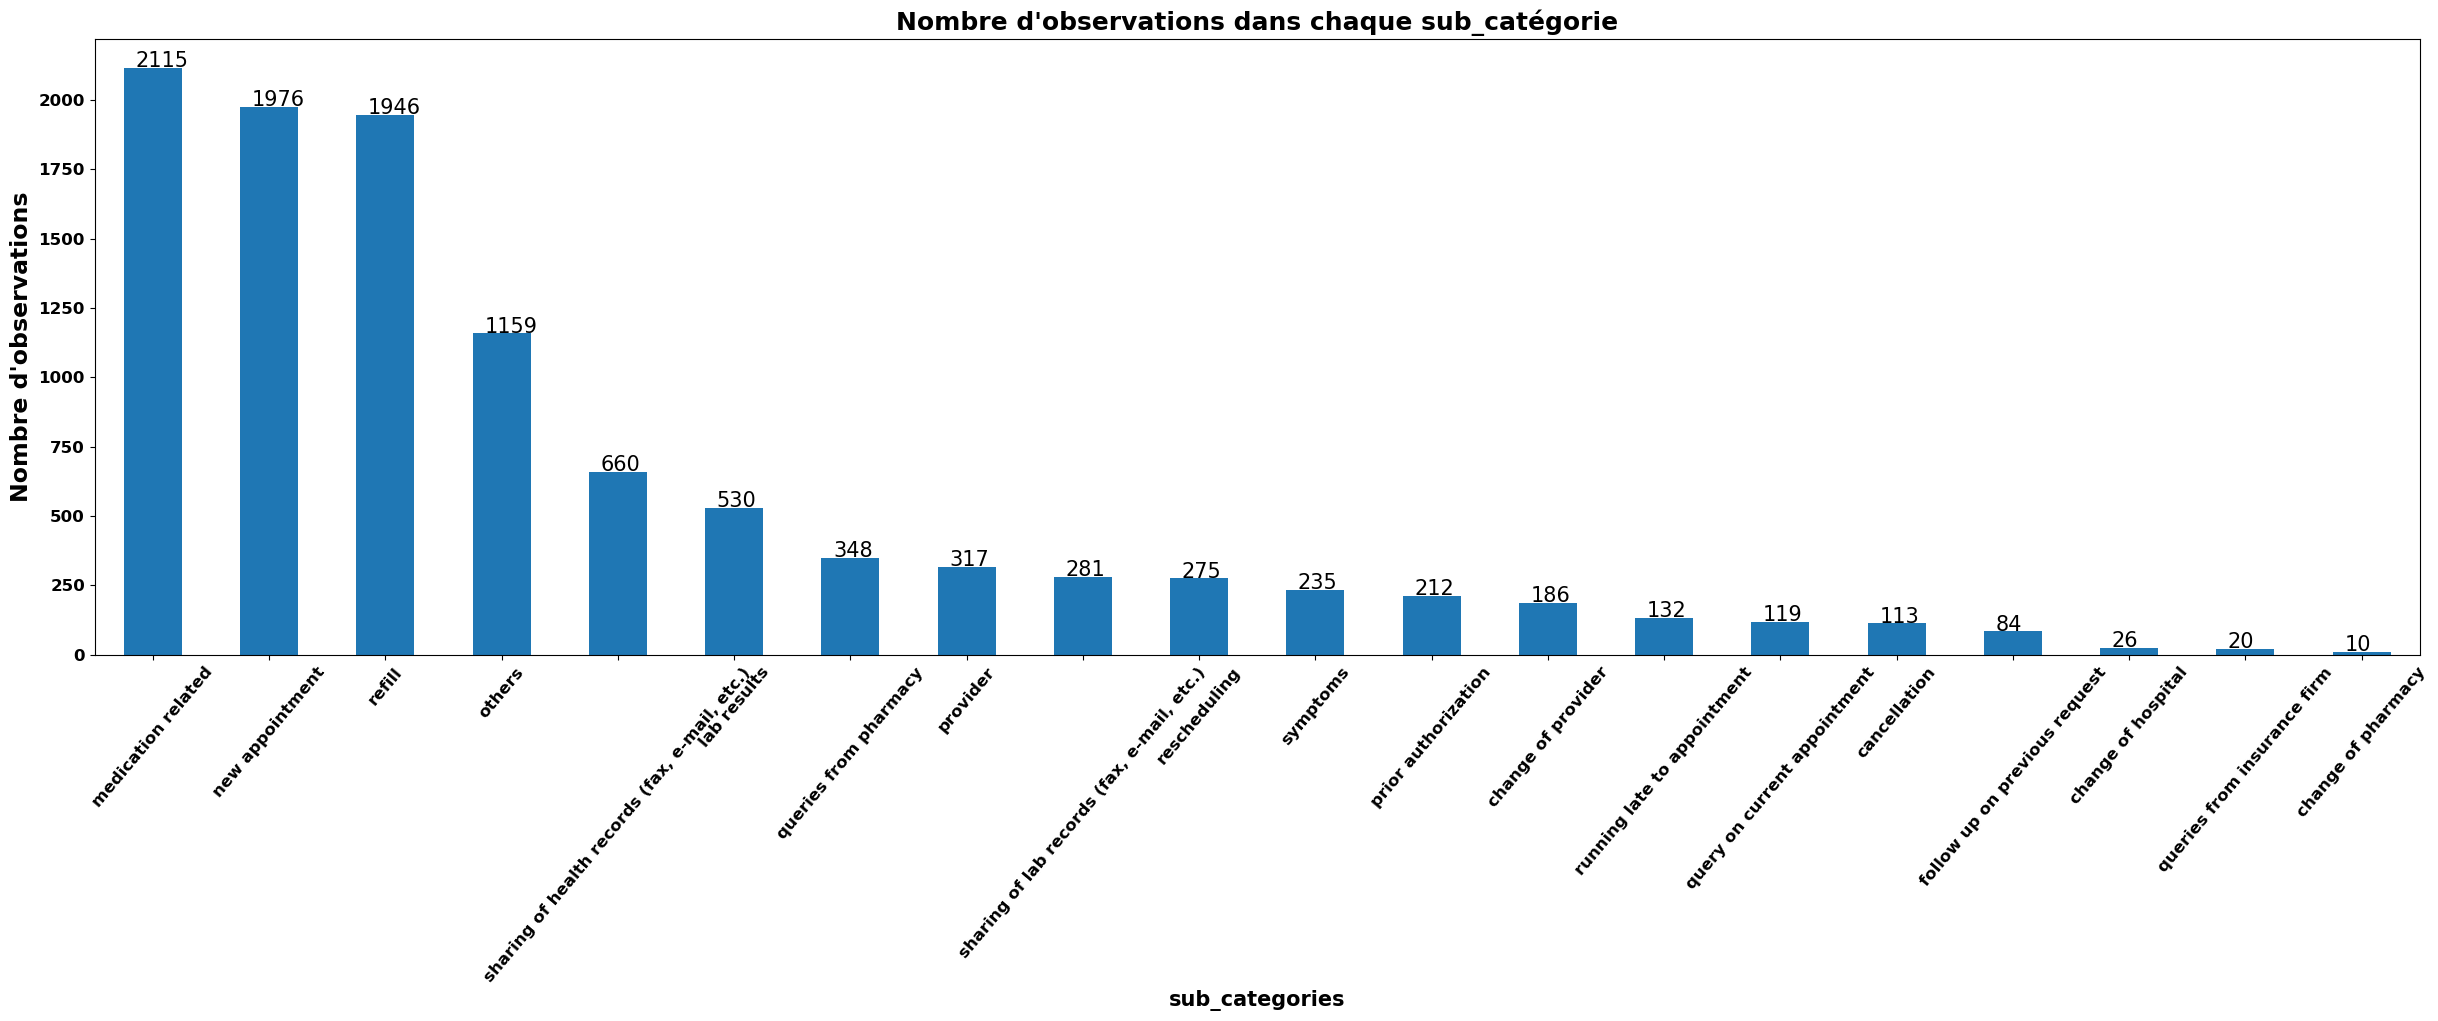

In [18]:
plt.subplots(figsize=(30,8))
ax=data['sub_categories'].value_counts().plot(kind='bar')
plt.xlabel('sub_categories',fontsize=15,fontweight='bold')
plt.xticks(rotation=50,fontsize=12,fontweight='bold')
plt.ylabel("Nombre d'observations",fontsize=17,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.title("Nombre d'observations dans chaque sub_catégorie",fontsize=18,fontweight='bold')
for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()+3, str(round(i.get_height(), 2)), fontsize=15, color='black')

plt.show()

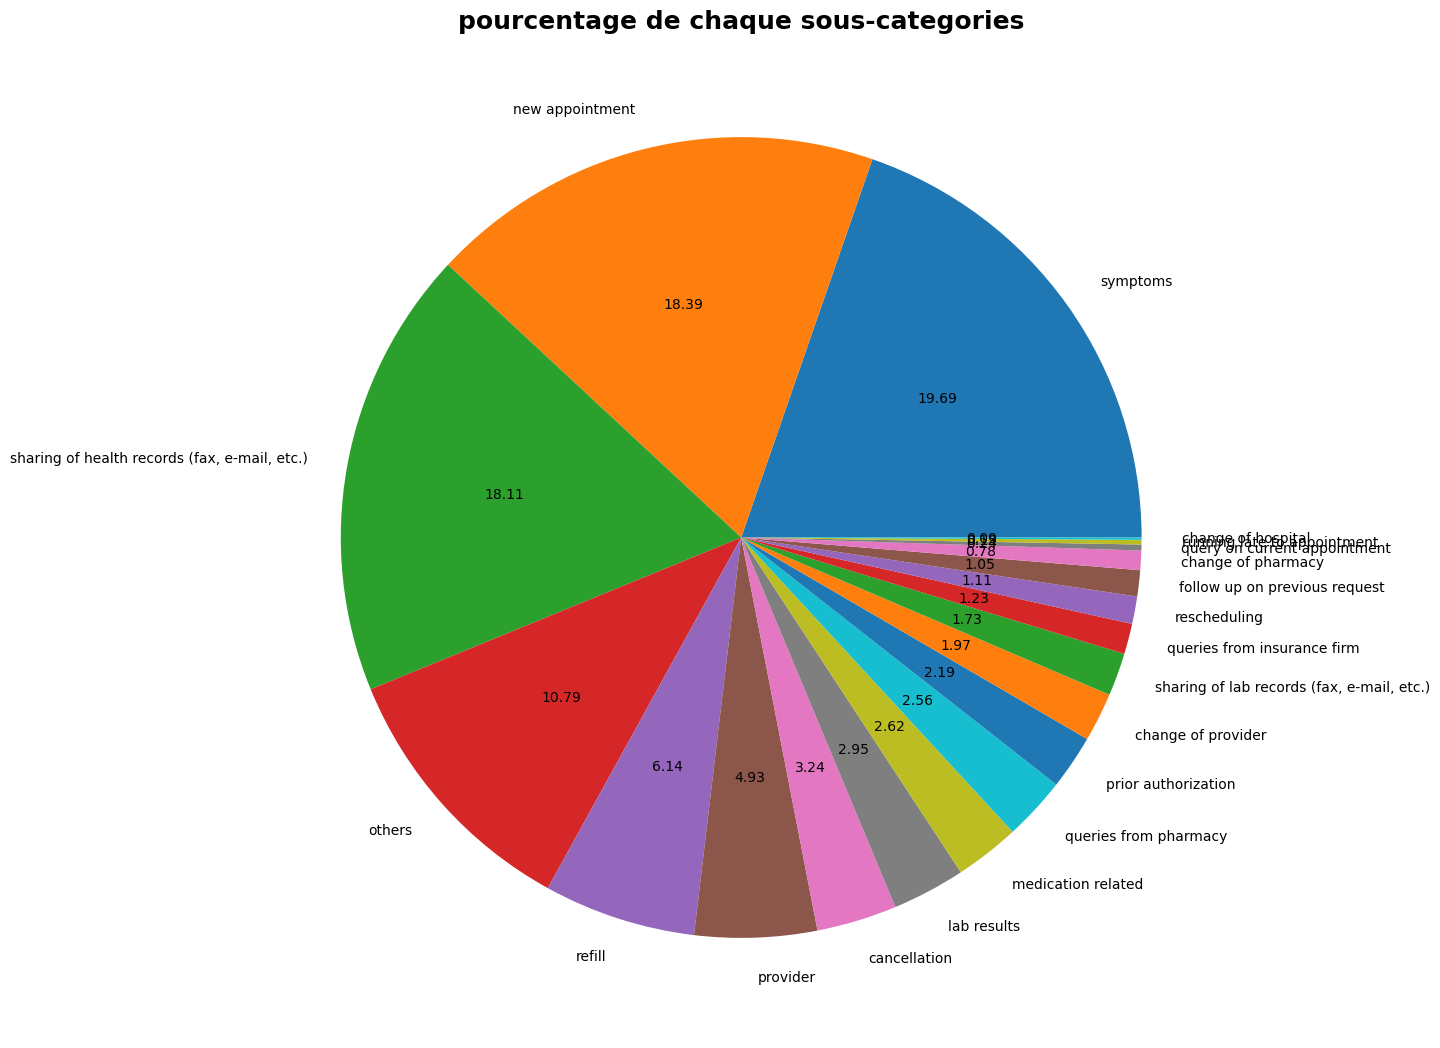

In [19]:
plt.subplots(figsize=(30,13))
plt.pie(data['sub_categories'].value_counts(),labels=['symptoms', 'new appointment',
       'sharing of health records (fax, e-mail, etc.)', 'others',
       'refill', 'provider', 'cancellation', 'lab results',
       'medication related', 'queries from pharmacy',
       'prior authorization', 'change of provider',
       'sharing of lab records (fax, e-mail, etc.)',
       'queries from insurance firm', 'rescheduling',
       'follow up on previous request', 'change of pharmacy',
       'query on current appointment', 'running late to appointment',
       'change of hospital'],autopct='%.2f')
plt.title("pourcentage de chaque sous-categories",fontsize=18,fontweight='bold')
plt.show()

In [20]:
data.sub_categories.unique()

array(['symptoms', 'new appointment',
       'sharing of health records (fax, e-mail, etc.)', 'others',
       'refill', 'provider', 'cancellation', 'lab results',
       'medication related', 'queries from pharmacy',
       'prior authorization', 'change of provider',
       'sharing of lab records (fax, e-mail, etc.)',
       'queries from insurance firm', 'rescheduling',
       'follow up on previous request', 'change of pharmacy',
       'query on current appointment', 'running late to appointment',
       'change of hospital'], dtype=object)

In [21]:
data.columns

Index(['SUMMARY', 'categories', 'sub_categories', 'previous_appointment',
       'ID'],
      dtype='object')

In [22]:
data['SUMMARY']

0              dizzy & double vision past 45 mins after CT
1                       pt clld to check on a work in appt
2                                                SCHEDULED
3                         Last office note faxed to NCEENT
4                             PCP Call - pt had concussion
                               ...                        
11456           pt's wife clld to spk with the RN about PT
11457    Phone Note-Jazz 14-002 Narcolepsy research stu...
11458                                      Judy from Xyrem
11459                   ADD ON w Holly for 05/13 @ 2:30 PM
11460         status of FMLA form?- awaiting MD completion
Name: SUMMARY, Length: 10744, dtype: object

In [23]:
string=data['SUMMARY'][0]
print(string)

dizzy & double vision past 45 mins after CT


In [24]:
stopW=stopwords.words("english")

In [25]:
def global_clean(text):
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    text = ''.join([i for i in text if not i.isdigit()])
    tokens = tokenizer.tokenize(text)
    tokens = [t.lower() for t in tokens]
    print(tokens)
    return tokens

In [26]:
global_clean(string)

['dizzy', 'double', 'vision', 'past', 'mins', 'after', 'ct']


['dizzy', 'double', 'vision', 'past', 'mins', 'after', 'ct']

In [27]:
data["SUMMARY_V"]=data["SUMMARY"].apply(lambda x: global_clean(x) )


['dizzy', 'double', 'vision', 'past', 'mins', 'after', 'ct']
['pt', 'clld', 'to', 'check', 'on', 'a', 'work', 'in', 'appt']
['scheduled']
['last', 'office', 'note', 'faxed', 'to', 'nceent']
['pcp', 'call', 'pt', 'had', 'concussion']
['rx', 'refill', 'request']
['nancy', 'from', 'new', 'hanover', 'hospital']
['intuniv', 'rx']
['mri', 'order', 'question']
['condition', 'update']
['pt', 'cancelled', 'her', 'sleep', 'study']
['dizziness', 'ent', 'appointment']
['mri', 'results']
['phone', 'note', 'seizure']
['headache', 'nausea', 'since', 'acetazolamide', 'decreased', 'to', 'day']
['rx', 'refill', 'dexedrine', 'get', 'rx', 'from', 'stk', 'and', 'print', 'two', 'more', 'friday']
['mri', 'sedation']
['sleep', 'rov', 'scheduled']
['new', 'sxs', 'w', 'migraines', 'eyes', 'swelling', 'shut']
['bupap', 'dose', 'change', 'rx', 'amended', 'called', 'to', 'rex']
['imetrix', 'not', 'helping', 'started', 'new', 'meds']
['needs', 'rov', 'for', 'refills', 'message', 'sent', 'to', 'schedulers']
['discus

In [31]:
data["SUMMARY_V"]


0           [dizzy, double, vision, past, mins, after, ct]
1             [pt, clld, to, check, on, a, work, in, appt]
2                                              [scheduled]
3                  [last, office, note, faxed, to, nceent]
4                         [pcp, call, pt, had, concussion]
                               ...                        
11456    [pt, s, wife, clld, to, spk, with, the, rn, ab...
11457    [phone, note, jazz, narcolepsy, research, stud...
11458                                  [judy, from, xyrem]
11459                         [add, on, w, holly, for, pm]
11460    [status, of, fmla, form, awaiting, md, complet...
Name: SUMMARY_V, Length: 10744, dtype: object

In [33]:
vector = TfidfVectorizer(analyzer=global_clean)
vector_f = vector.fit_transform(data['SUMMARY'])


['dizzy', 'double', 'vision', 'past', 'mins', 'after', 'ct']
['pt', 'clld', 'to', 'check', 'on', 'a', 'work', 'in', 'appt']
['scheduled']
['last', 'office', 'note', 'faxed', 'to', 'nceent']
['pcp', 'call', 'pt', 'had', 'concussion']
['rx', 'refill', 'request']
['nancy', 'from', 'new', 'hanover', 'hospital']
['intuniv', 'rx']
['mri', 'order', 'question']
['condition', 'update']
['pt', 'cancelled', 'her', 'sleep', 'study']
['dizziness', 'ent', 'appointment']
['mri', 'results']
['phone', 'note', 'seizure']
['headache', 'nausea', 'since', 'acetazolamide', 'decreased', 'to', 'day']
['rx', 'refill', 'dexedrine', 'get', 'rx', 'from', 'stk', 'and', 'print', 'two', 'more', 'friday']
['mri', 'sedation']
['sleep', 'rov', 'scheduled']
['new', 'sxs', 'w', 'migraines', 'eyes', 'swelling', 'shut']
['bupap', 'dose', 'change', 'rx', 'amended', 'called', 'to', 'rex']
['imetrix', 'not', 'helping', 'started', 'new', 'meds']
['needs', 'rov', 'for', 'refills', 'message', 'sent', 'to', 'schedulers']
['discus

In [34]:
tfidf_matrix=pd.DataFrame(vector_f.toarray())


In [35]:
tfidf_matrix.shape


(10744, 4016)

In [36]:
tfidf_matrix

,0,1,2,3,4,5,6,7,8,9,...,4006,4007,4008,4009,4010,4011,4012,4013,4014,4015
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.330364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10739,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10740,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10741,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10742,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
tfidfT=tfidf_matrix.T

In [38]:
tfidfT

,0,1,2,3,4,5,6,7,8,9,...,10734,10735,10736,10737,10738,10739,10740,10741,10742,10743
0,0.0,0.330364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4011,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4012,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4013,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4014,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
moy=[]
for i in range(tfidf_matrix.shape[1]):
    moy.append(tfidf_matrix[i].sum())
moy

[122.47375960408814,
 0.36331907648981765,
 0.551735119977673,
 0.4158805963178619,
 1.261570762139182,
 6.793043962975959,
 0.5770310203737788,
 0.8400083937031155,
 4.859069446647776,
 0.36600241133029826,
 0.5648093929484141,
 85.54230493927308,
 0.6519068338139594,
 0.6598424064979201,
 0.4905320371714807,
 0.44577040062146017,
 19.576498497404078,
 0.5993305034862362,
 0.3808405506159246,
 1.0850718154794854,
 0.5617624678854463,
 3.649427483796388,
 2.0645743402831624,
 4.6572204958912415,
 2.130792556734831,
 0.45438441390161943,
 0.4857562891727014,
 0.5015704553521738,
 0.4290222768933073,
 1.6085541301208295,
 0.5329186143282437,
 0.7592174795002313,
 1.5854903841365369,
 0.5035745776175048,
 0.5613846678097958,
 0.6447302089609139,
 0.6701525527112611,
 0.38243212268097093,
 0.5922630684875787,
 1.6548955124773617,
 6.832894250817024,
 0.8107649294894499,
 3.795653939047213,
 3.61462452531354,
 0.4852319521208549,
 7.547064474512263,
 0.6204100698750534,
 0.5655726273744971,

In [42]:
ex=[]
for i in range(tfidf_matrix.shape[1]):
    if np.sum(tfidf_matrix[i].values)>np.mean(moy):
        ex.append(i)

In [43]:
tfidf_matrix.shape

(10744, 4016)

In [44]:
tfidf_red=tfidf_matrix.drop(ex, axis=1)

In [45]:
tfidf_matrix

,0,1,2,3,4,5,6,7,8,9,...,4006,4007,4008,4009,4010,4011,4012,4013,4014,4015
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.330364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10739,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10740,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10741,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10742,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
tfidf_red.shape

(10744, 3370)

In [47]:
features=vector.get_feature_names()

C:\Users\hadhi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [48]:
featuresExist = [features[k] for k in tfidf_red.columns]

In [49]:
featuresExist

['ab',
 'abby',
 'abbygail',
 'abdominal',
 'abilities',
 'abl',
 'able',
 'abo',
 'abot',
 'above',
 'abr',
 'absence',
 'absent',
 'abuse',
 'abx',
 'ac',
 'acaria',
 'accept',
 'accepts',
 'access',
 'accident',
 'accidentally',
 'accomodate',
 'accomodations',
 'account',
 'accredo',
 'acct',
 'acet',
 'acetaminophen',
 'acetazolamide',
 'ache',
 'aching',
 'achtar',
 'acid',
 'acrredo',
 'acs',
 'acting',
 'action',
 'active',
 'activist',
 'acute',
 'acyclovir',
 'addendum',
 'adderal',
 'adderalll',
 'adding',
 'addition',
 'additonal',
 'addl',
 'addon',
 'addressed',
 'addtional',
 'adhd',
 'adivse',
 'adjust',
 'adjusted',
 'adjustment',
 'adjustments',
 'administration',
 'admission',
 'admisson',
 'admit',
 'admits',
 'admittance',
 'admitted',
 'admtiting',
 'adult',
 'adv',
 'advance',
 'advanced',
 'adverse',
 'advice',
 'advil',
 'advis',
 'advisefor',
 'advisehead',
 'advising',
 'advisment',
 'ae',
 'aeds',
 'aes',
 'aetna',
 'af',
 'affidavit',
 'afford',
 'aflac',
 

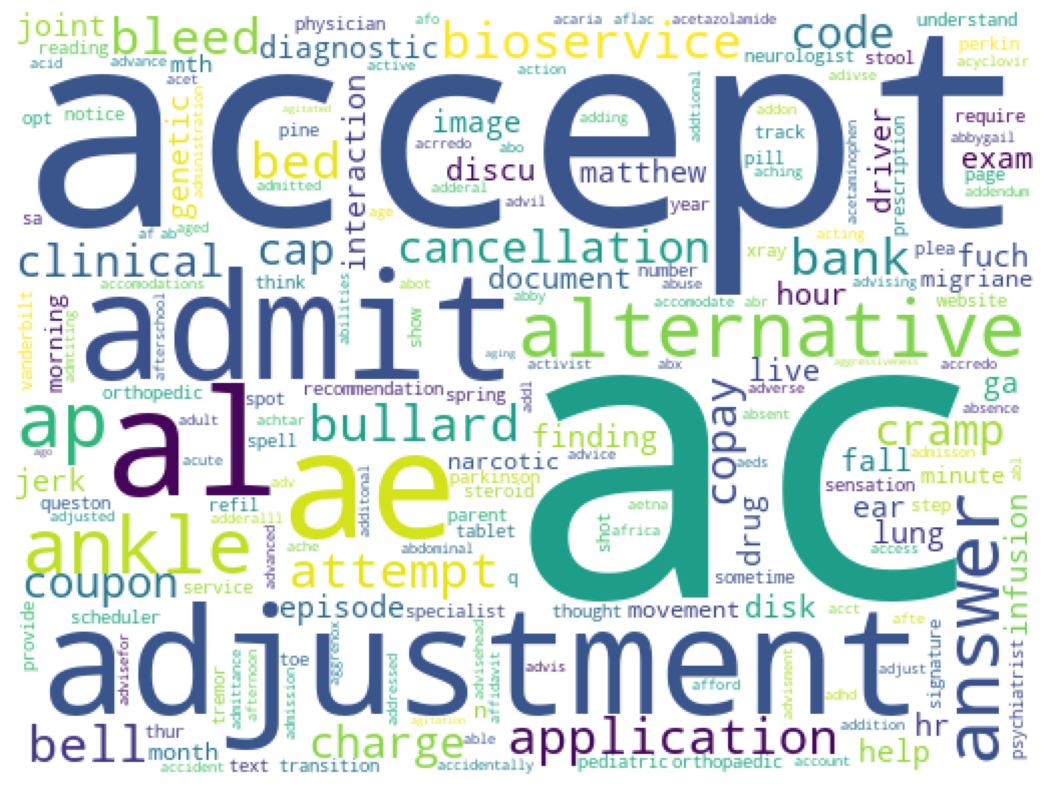

In [50]:
plt.subplots(figsize=(20,10))

wordcloud = WordCloud(background_color = 'white',
                     width = 512,
                     height = 384).generate(' '.join(featuresExist))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [55]:
target = LabelEncoder().fit_transform(data['categories'])

data_features = tfidf_matrix

X_train,X_test,y_train,y_test=train_test_split(data_features,target,test_size=0.3)

In [56]:
from sklearn.linear_model import LogisticRegression

#modele=LogisticRegression(penalty='none',solver='newton-cg')
modele=LogisticRegression()
modele.fit(X_train,y_train)

C:\Users\hadhi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [57]:
y = modele.predict(X_test)

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix,precision_recall_fscore_support as precis, classification_report

accuracy_score(y,y_test)

0.7450372208436724

Essayons un autre algorithme

In [59]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train,y_train)

RandomForestClassifier()

In [60]:
y_randF = classifier.predict(X_test)

In [62]:
accuracy_score(y_randF,y_test)

0.7316997518610422

In [63]:
confusion_matrix(y_randF,y_test)

array([[626,  47,  13,  40,  22],
       [ 60, 474,  23, 138,  99],
       [  9,   7, 164,   7,  11],
       [ 53,  93,  43, 391,  56],
       [ 16,  71,  15,  42, 704]], dtype=int64)

<AxesSubplot: >

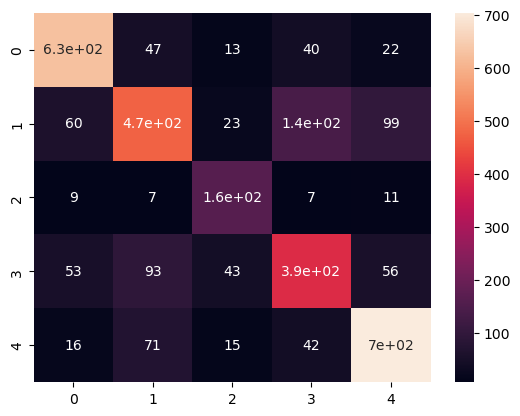

In [66]:
conf = confusion_matrix(y_randF,y_test)
sea.heatmap(conf, annot=True)

In [67]:
precis(y_test,y_randF)

(array([0.8368984 , 0.59697733, 0.82828283, 0.61477987, 0.83018868]),
 array([0.81937173, 0.6849711 , 0.63565891, 0.63268608, 0.78923767]),
 array([0.82804233, 0.63795424, 0.71929825, 0.62360447, 0.8091954 ]),
 array([764, 692, 258, 618, 892], dtype=int64))

In [68]:
print("Random Forest: ")
print(classification_report(y_test, y_randF))
print("Logistic Regression ")
print(classification_report(y_test, y))

Random Forest: 
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       764
           1       0.60      0.68      0.64       692
           2       0.83      0.64      0.72       258
           3       0.61      0.63      0.62       618
           4       0.83      0.79      0.81       892

    accuracy                           0.73      3224
   macro avg       0.74      0.71      0.72      3224
weighted avg       0.74      0.73      0.73      3224

Logistic Regression 
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       764
           1       0.64      0.72      0.68       692
           2       0.90      0.59      0.71       258
           3       0.60      0.65      0.62       618
           4       0.84      0.81      0.83       892

    accuracy                           0.75      3224
   macro avg       0.76      0.72      0.73      3224
weighted avg       0.76      0.75      0